In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np, scipy as sp, pandas as pd
import struct
from scipy import signal
from sigflux.wave import cwtlets
import sigflux 

from numpy.fft import fft, ifft

### Notes

* Sample rate of waveform is 5 Hz 
* Bit depth appears to be higher than 8 bit

#### Run length

* Jul 17 - 7:50:06 (28206 s)

In [2]:
def hr(byteslike):
#     bytelist = [struct.unpack('B', b) for b in byteslike]
    return ' '.join(['{:#04x}'.format(b)[2:] for b in byteslike])

In [3]:
path = "/home/mike/data/dreamstation/170716/00000040.005"

In [4]:
with open(path, 'rb') as f:
    rawdata = f.read()

In [5]:
type(rawdata), len(rawdata)

(bytes, 144447)

In [6]:
b = rawdata[1:2]

In [7]:
b, struct.unpack('B', b)

(b'\xcd', (205,))

In [8]:
hr(rawdata[:10])

'03 cd 04 01 00 06 05 40 00 00'

In [9]:
print('{:#04x}'.format(3))

0x03


In [10]:
inlist = [int(b) for b in rawdata]

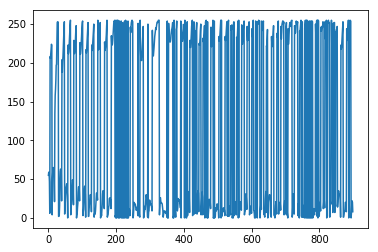

In [11]:
plt.plot(inlist[100:1000])

In [12]:
sig = np.array(inlist[:10000])
wmax = 128
widths = np.arange(1, wmax)
cwtmatr = sigflux.cwt(sig, cwtlets.hatlet, widths)

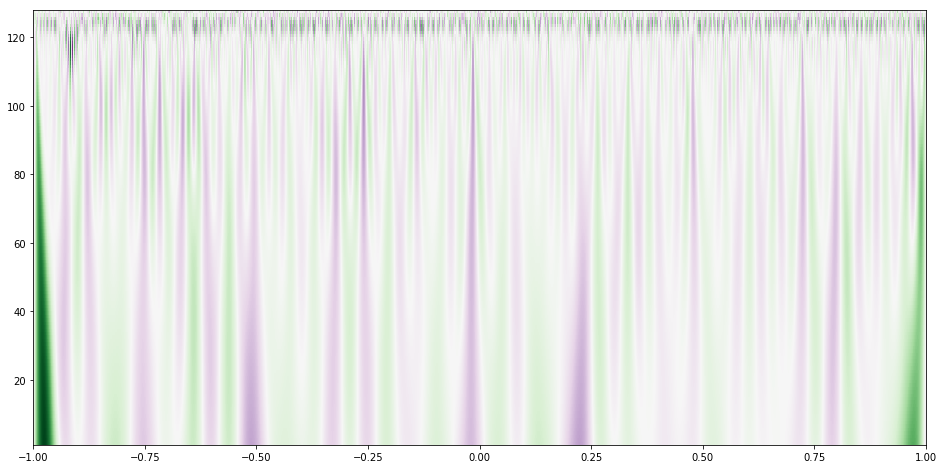

In [13]:
rcParams['figure.figsize'] = (16,8)
img = np.real(cwtmatr)
plt.imshow(img, extent=[-1, 1, 1, wmax], cmap='PRGn', aspect='auto',
           vmax=abs(img).max(), vmin=-abs(img).max())

In [14]:
cwtmatr.shape

(127, 10000)

In [15]:
cwta = signal.hilbert(np.real(cwtmatr), axis=1)

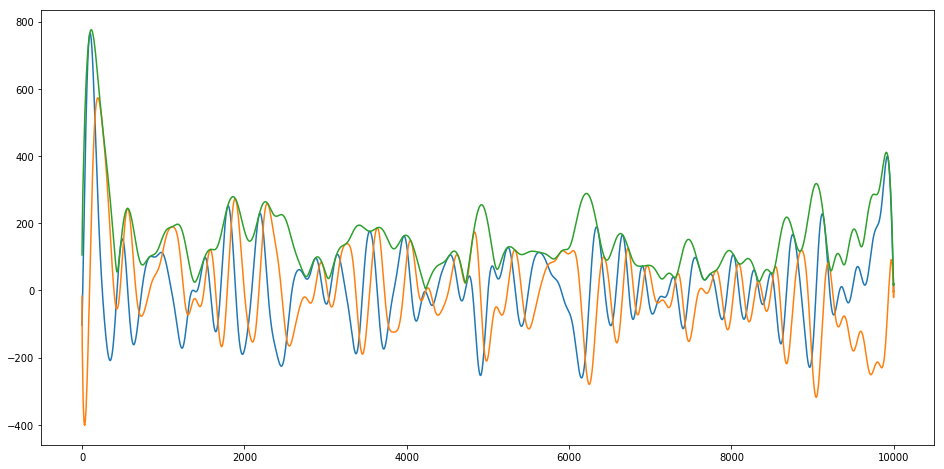

In [16]:
n = 88
plt.plot(np.real(cwta[n]))
plt.plot(np.imag(cwta[n]))
plt.plot(np.abs(cwta[n]))

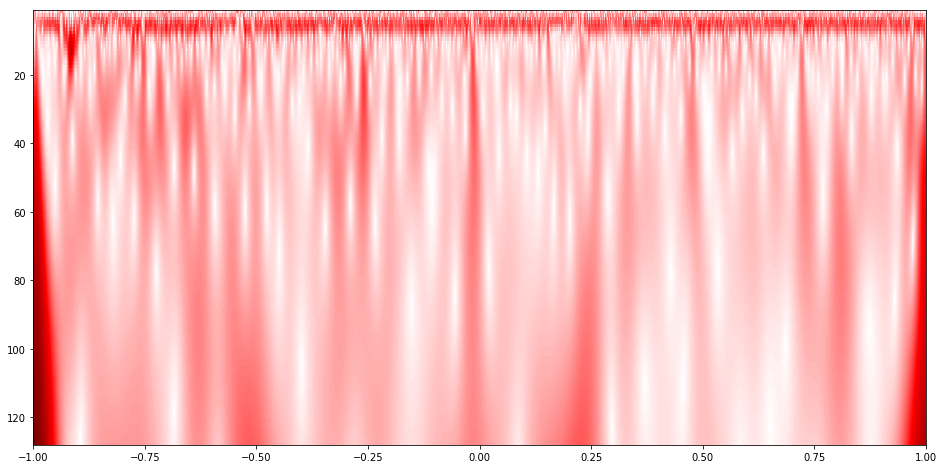

In [17]:
wmax = 128
widths = np.arange(1, wmax)
cwtmatr = sigflux.cwt(sig, cwtlets.hatlet, widths)
img = np.abs(cwtmatr)
plt.imshow(img, extent=[-1, 1, wmax, 1], cmap='seismic', aspect='auto',
           vmax=abs(img).max(), vmin=-abs(img).max())

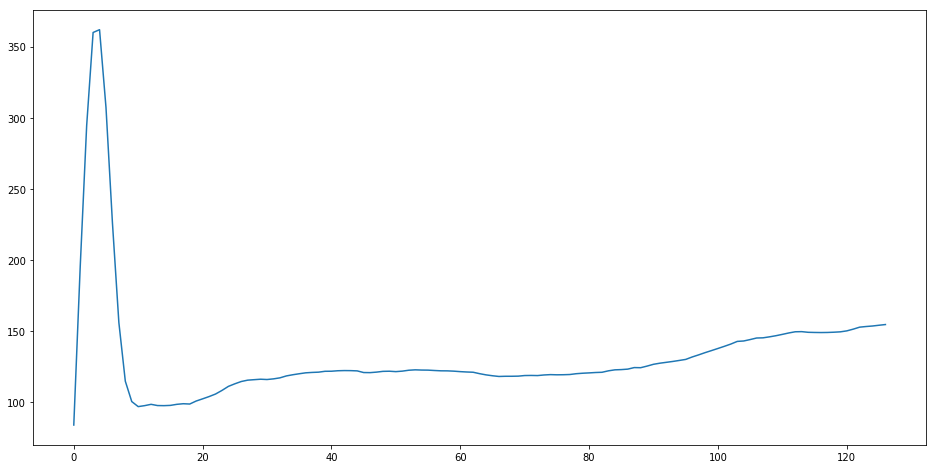

In [18]:
plt.plot(np.median(np.abs(cwta), axis=1))

In [19]:
def header_print(rawdata):
    print('00:', hr(rawdata[:1]), 'DataFormatVersion')
    print('01:', hr(rawdata[1:3]), 'BlockLength (in bytes)')
    print('03:', hr(rawdata[3:4]))
    print('04:', hr(rawdata[4:5]))
    print('05:', hr(rawdata[5:6]))
    print('06:', hr(rawdata[6:7]))
    print('07:', hr(rawdata[7:0xb]))
    print('0b:', hr(rawdata[0xb:0xf]))

header_print(rawdata)

00: 03 DataFormatVersion
01: cd 04 BlockLength (in bytes)
03: 01
04: 00
05: 06
06: 05
07: 40 00 00 00
0b: 51 33 6c 59


In [107]:
struct.unpack('HBBBB', rawdata[1:7])

(1229, 1, 0, 6, 5)

In [85]:
struct.unpack("B", rawdata[0:1])[0]

3

In [20]:
bs = struct.unpack("H", rawdata[1:3])[0]
bs

1229

In [21]:
t = struct.unpack("I", rawdata[0xb:0xf])
print(t)
print(pd.to_datetime(t[0], unit='s'))

(1500263249,)
2017-07-17 03:47:29


In [22]:
def header_wave(rawdata):
    print('0f:', hr(rawdata[0xf:0x11]))
    print('11:', hr(rawdata[0x11:0x12]))
    print('12:', hr(rawdata[0x12:0x14]), '\tnsig')
    print('14:', hr(rawdata[0x14:0x16]), '\tSample interleave')
    print('16:', hr(rawdata[0x16:0x17]), '\t\tSample format')

header_wave(rawdata)

0f: f0 00
11: 01
12: 01 00 	nsig
14: 05 00 	Sample interleave
16: 08 		Sample format


In [23]:
hr(rawdata[0x17:0x25])

'00 68 e5 fd 16 21 27 36 37 31 2c 1f cd b9'

In [24]:
rawdata[0x12:0x14]

b'\x01\x00'

In [25]:
struct.unpack('H', rawdata[0x12:0x14])

(1,)

In [26]:
struct.pack('H', 16)

b'\x10\x00'

In [27]:
### DataSize = BlockLength – HeaderLength – Extra Header stuff – 1 byte header checksum – 2 byte block checksum


In [28]:
def deinterleave(byteslike, offset=0, leaf=1, skipbytes=20):
    start = skipbytes + offset
    

In [29]:
SS = 28206
Hz = 5

In [30]:
filesize = len(rawdata)
datasize = filesize - 0x17

In [31]:
datasize / (SS * Hz)

1.024065801602496

In [32]:
filesize - (SS * Hz)

3417

In [33]:
def extract(rawdata, num=100, offset=100, dtype='B' ):
    step = {'B':1, 'H':2}[dtype.upper()]
    stop = offset + num*step
    section = rawdata[offset:stop]
    return list(struct.unpack('{}{}'.format(num, dtype), section))

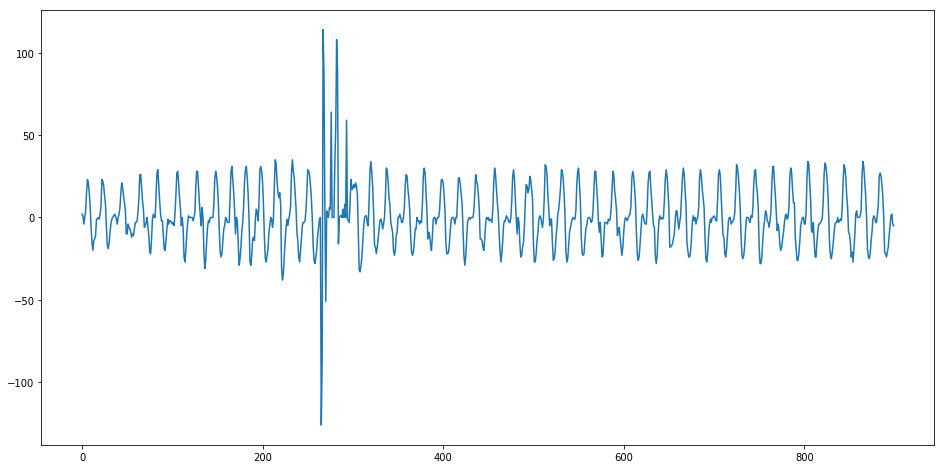

In [34]:
plt.plot(extract(rawdata, num=900, offset=3418, dtype='b'))

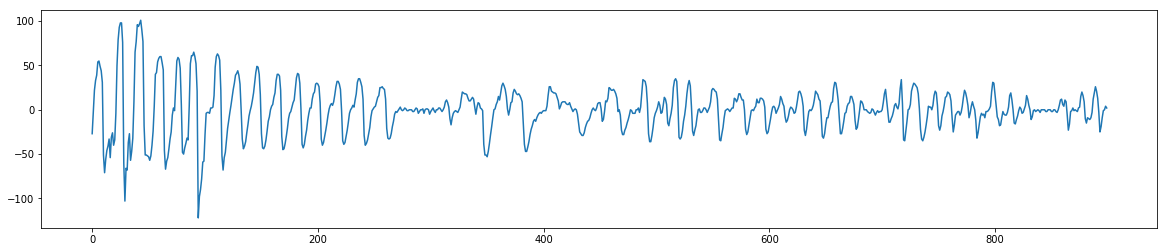

In [35]:
rcParams['figure.figsize'] = (20,4)
plt.plot(extract(rawdata, num=900, offset=0x19, dtype='b'))

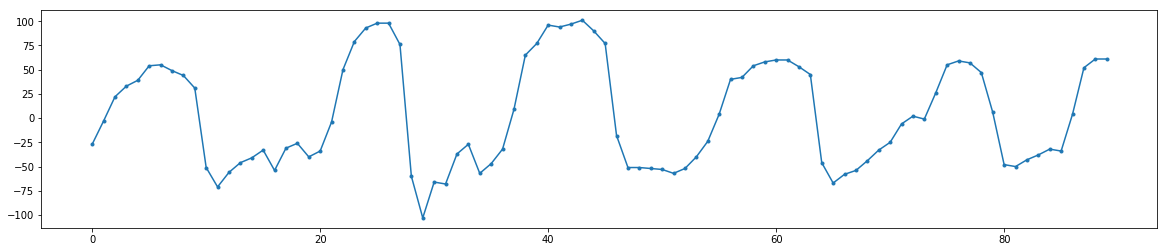

In [36]:
plt.plot(extract(rawdata, num=90, offset=0x19, dtype='b'), '.-')

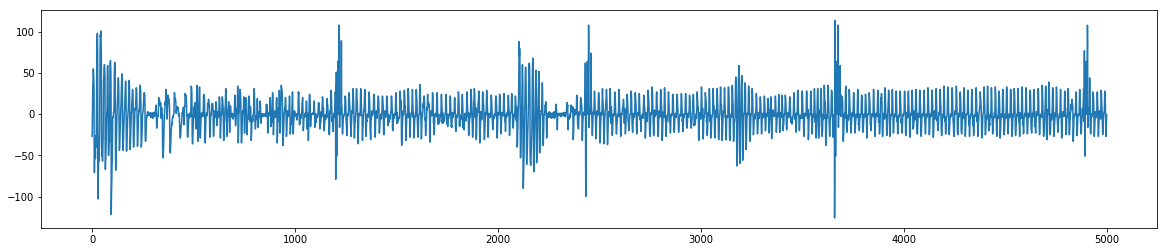

In [37]:
plt.plot(extract(rawdata, num=5000, offset=0x19, dtype='b'))

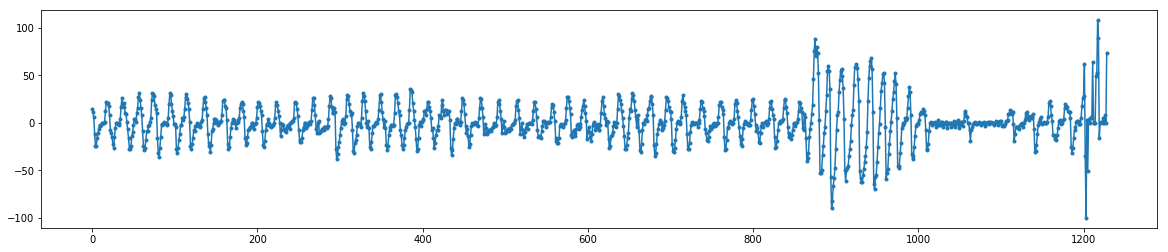

In [38]:
plt.plot(extract(rawdata, num=bs, offset=0x19+1*bs, dtype='b'), '.-')

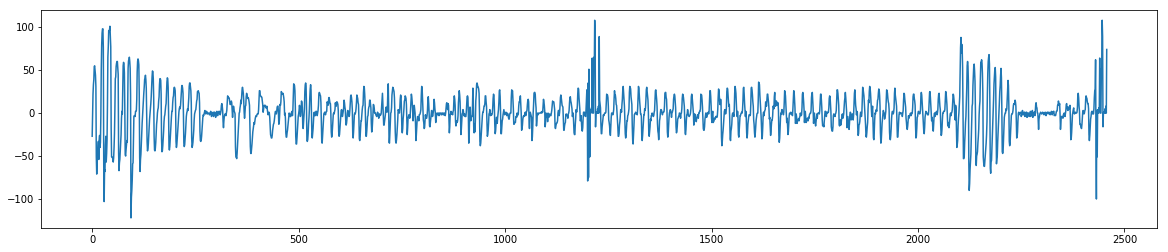

In [39]:
sig = extract(rawdata, num=bs, offset=0x19+0*bs, dtype='b') + extract(rawdata, num=bs, offset=0x19+1*bs, dtype='b')
plt.plot(sig)

DataSize = BlockLength – HeaderLength – Extra Header stuff – 1 byte header checksum – 2 byte block checksum

In [40]:
nan = float('nan')

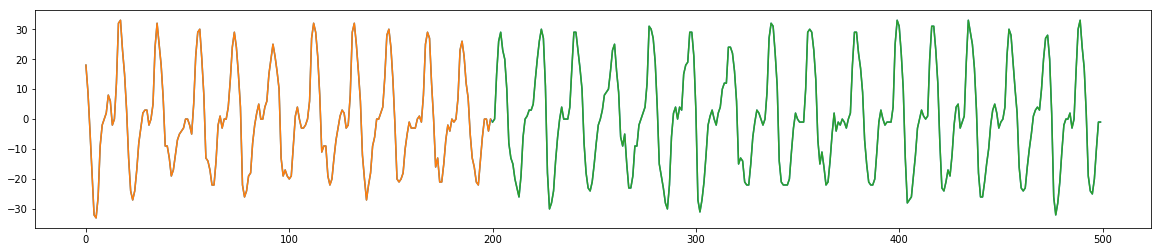

In [41]:
n = 7
base= 0x19 #x20
header = 0x19
headcx = 1
blockcx = 2
hs = 29
fullhead = header + headcx
siga = extract(rawdata, num=bs, offset=base+(n)*bs, dtype='b')[:-29]
sigb = extract(rawdata, num=bs, offset=base+(n+1)*bs, dtype='b')[:]

sig = siga + sigb
sig1 = list(siga) + [nan for _ in sigb]
sig2 = [nan for _ in siga] + list(sigb)
x0, x1 = 1000, 1500
plt.plot(sig[x0:x1])
plt.plot(sig1[x0:x1])
plt.plot(sig2[x0:x1])

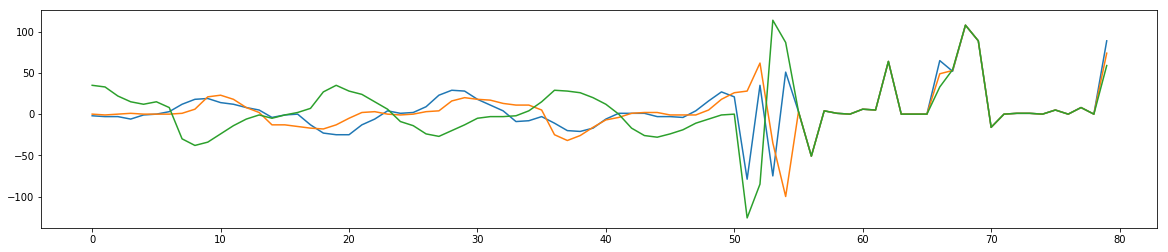

In [42]:
first = extract(rawdata, num=bs, offset=0x19, dtype='b')
second = extract(rawdata, num=bs, offset=0x19+bs, dtype='b')
third = extract(rawdata, num=bs, offset=0x19+2*bs, dtype='b')

n = -80
plt.plot(first[n:], '-')
# plt.plot([nan for _ in first] + second)
plt.plot(second[n:])
plt.plot(third[n:])

In [43]:
streams = []
for i in range(110):
    dd = extract(rawdata, num=bs, offset=0x19+i*bs, dtype='b')
    streams.append(dd)

In [44]:
a = np.array(streams)

In [45]:
a.shape

(110, 1229)

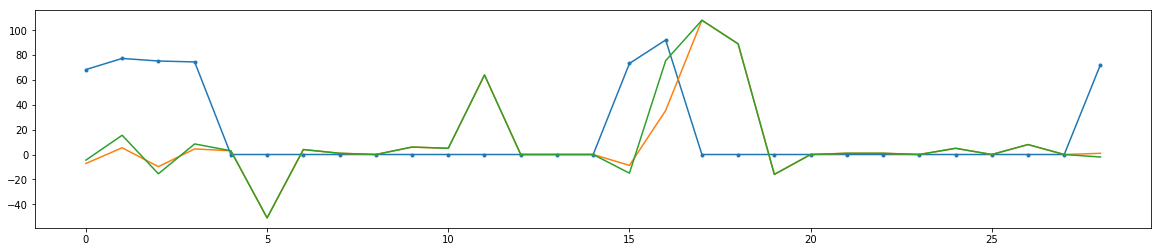

In [46]:
n = -29
plt.plot(np.std(a, axis=0)[n:], '.-')
plt.plot(np.mean(a, axis=0)[n:])
plt.plot(np.median(a, axis=0)[n:])

29 appears to be the header size on all future headers

In [47]:
hs = 29
hex(hs)

'0x1d'

In [48]:
0x19

25

In [49]:
def extract_waveform(rawdata, blocksize=1229, topheader=0x19, waveheader=0x1d):
    streams = []
    idx = 0
    trimmedData = rawdata[topheader:]
    while True:
        try:
            dd = np.array(extract(trimmedData, num=blocksize, offset=idx*blocksize, dtype='b'))
        except Exception:
            print('end')
            break
        dd = dd[:-waveheader]
        streams.append(dd)
        idx += 1
    return streams
    

In [50]:
a = extract_waveform(rawdata, waveheader=0x1d)
a = np.array(a)
print(a.shape)
# plt.plot(a[:3].T)

end
(117, 1200)


(140400,)
16.9431858389


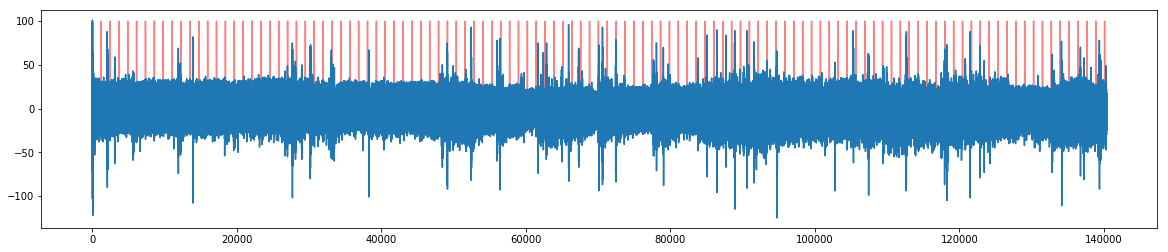

In [51]:
sig = np.concatenate(a, axis=0)
sigd = np.diff(sig)

spikes = np.zeros(len(sig))
spikes[::bs] = 100
spikes[1::bs] = 100
spikes[2::bs] = 100

print(sig.shape)
print(np.std(sig))
plt.plot(spikes, 'r', alpha=0.5)
plt.plot(sig)
# plt.plot(np.diff(sig))

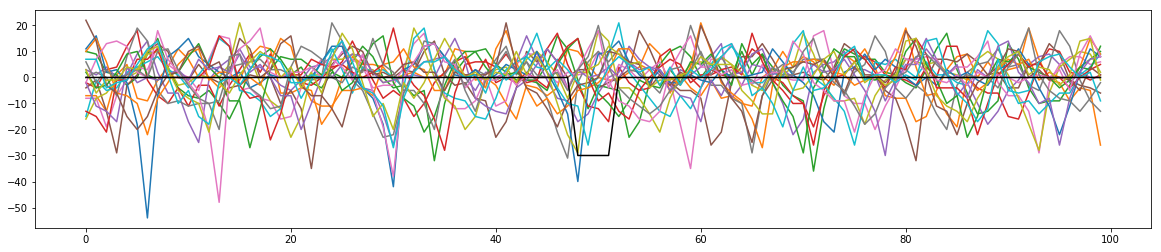

In [52]:


for i in range(20):
    mysig = sigd
    y = sigd[i*bs-50:i*bs+50]
    n = len(y)


    plt.plot(y)
    
mask = np.zeros(n)
mask[n//2-2:n//2+2] = -30
plt.plot(mask, 'k')

83.2962494617


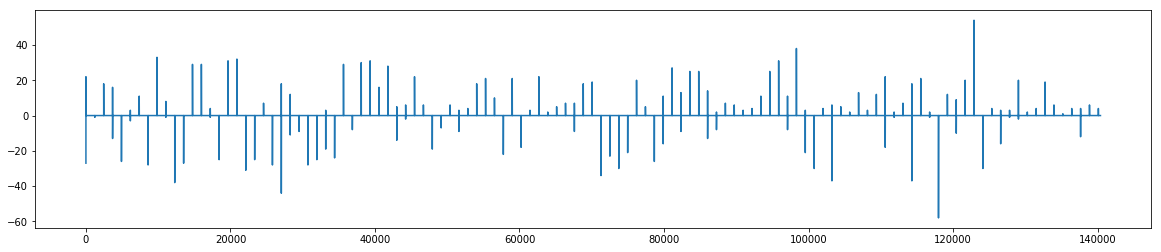

In [53]:
print(np.std(spikes*sig))
plt.plot(spikes * sig*.01)

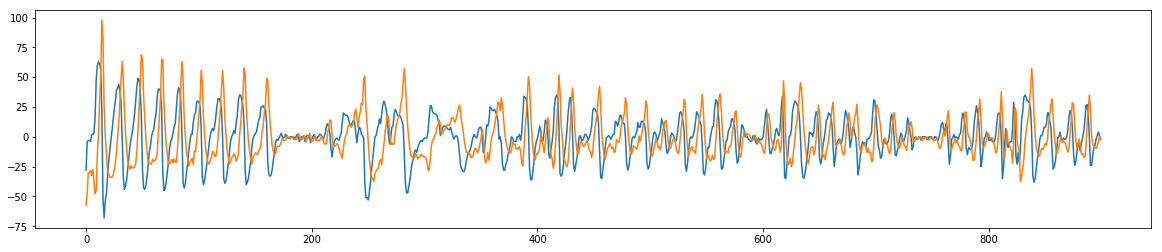

In [54]:
siga = signal.hilbert(sig)
n = 900
k = 100
y = siga[k:k+n]
plt.plot(np.real(y))
plt.plot(np.imag(y))

In [80]:

wmax = 64
widths = np.linspace(1, wmax**0.5, 256)**2
y = sig[:len(sig)//4]
cwtmatr = sigflux.cwt(y, cwtlets.hatlet, widths)

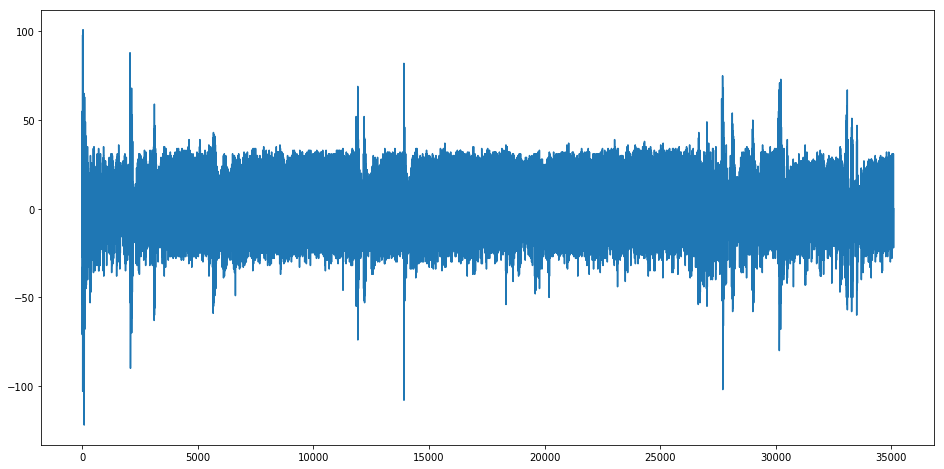

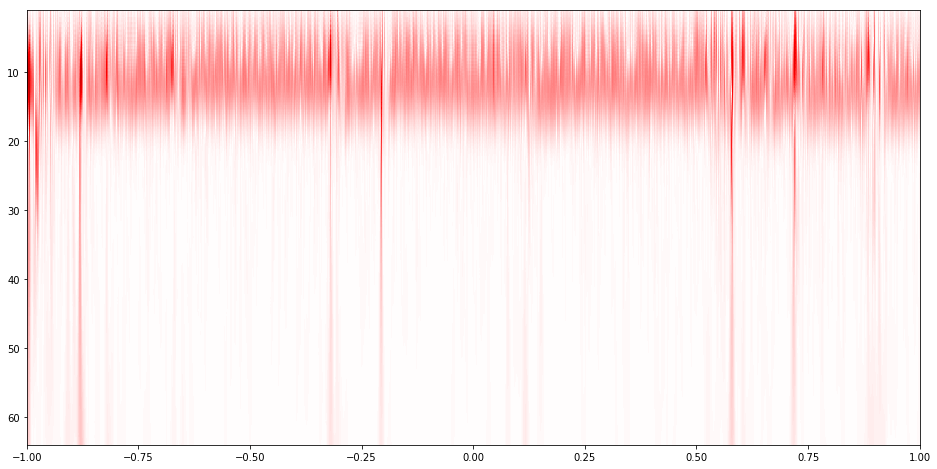

In [81]:
rcParams['figure.figsize'] = (16,8)
img = np.abs(cwtmatr)
plt.plot(y)
plt.figure()
plt.imshow(img, extent=[-1, 1, wmax, 1], cmap='seismic', aspect='auto',
           vmax=abs(img).max(), vmin=-abs(img).max())


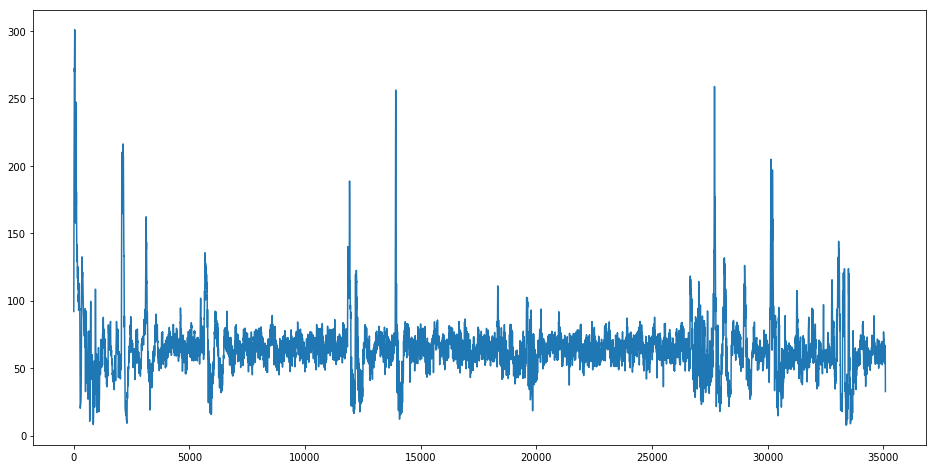

In [82]:
plt.plot(np.max(img, axis=0))

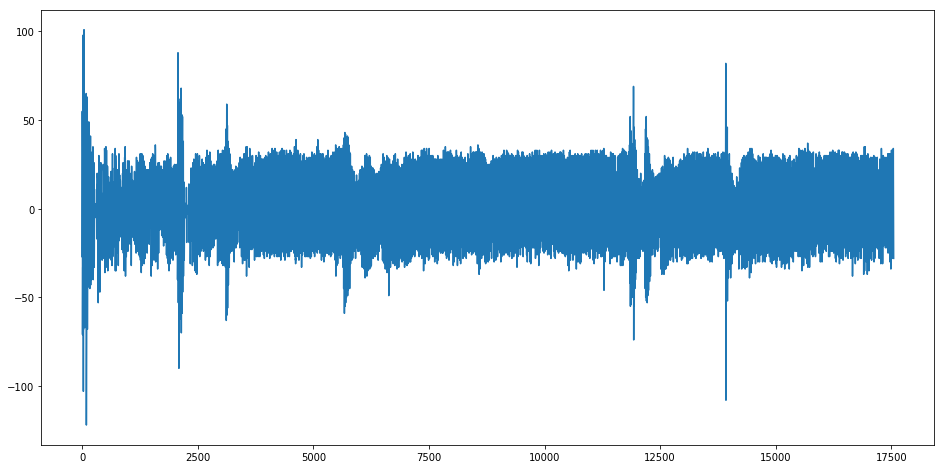

In [57]:
plt.plot(y)


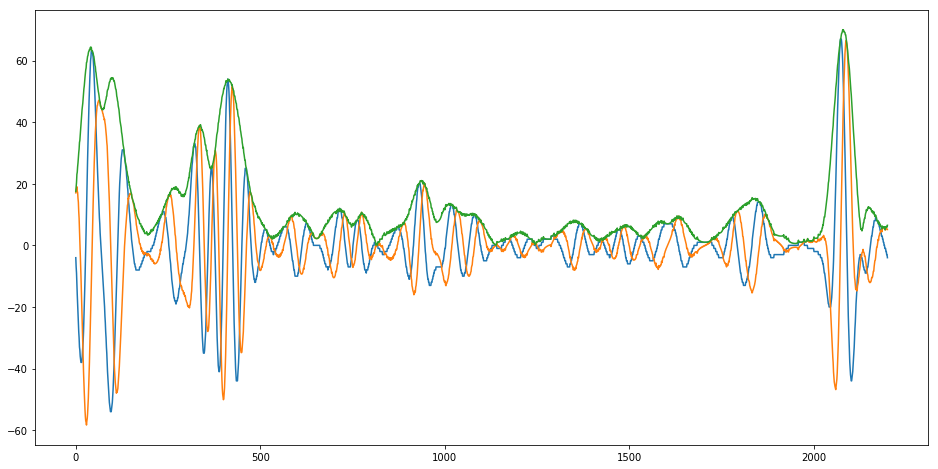

In [58]:
cwta = signal.hilbert(cwtmatr, axis=1)
n = 120
k = 2200
plt.plot(np.real(cwta[n])[:k])
plt.plot(np.imag(cwta[n])[:k])
plt.plot(np.abs(cwta[n])[:k])

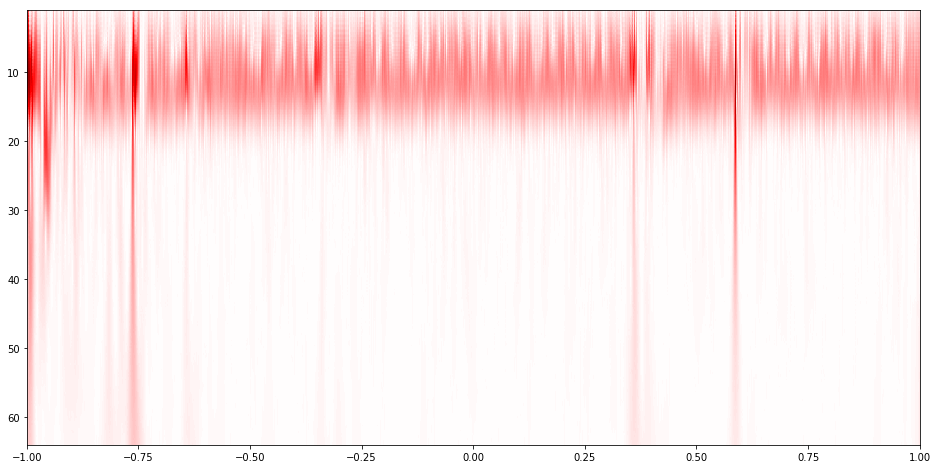

In [59]:
rcParams['figure.figsize'] = (16,8)
plt.imshow(np.abs(cwta), extent=[-1, 1, wmax, 1], cmap='seismic', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


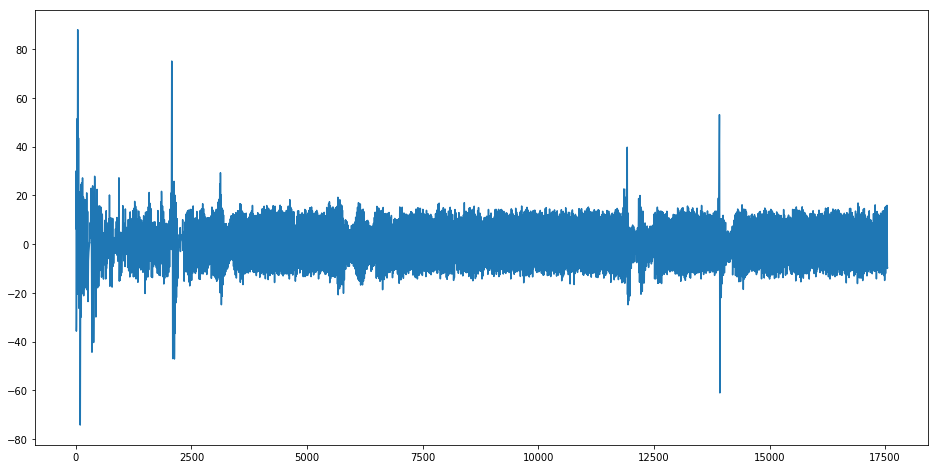

In [60]:
plt.plot(np.mean(cwta, axis=0))

In [61]:
igr = sp.integrate.cumtrapz(sig)

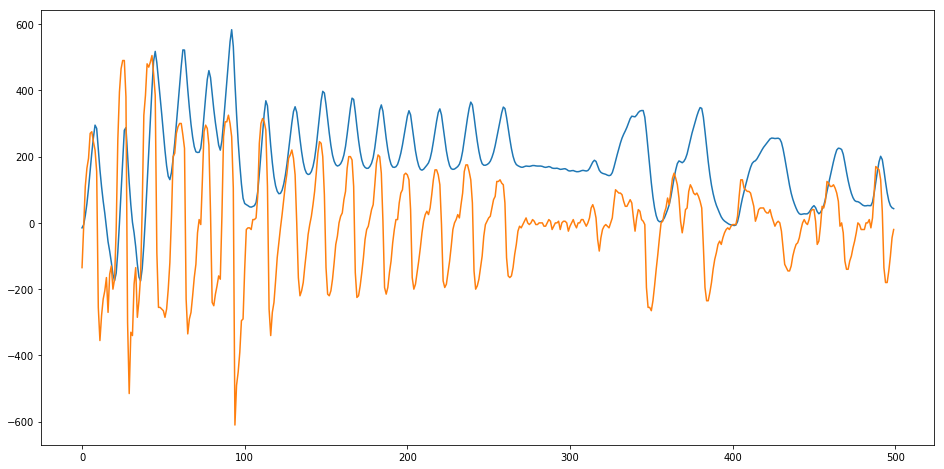

In [62]:
k = 500
plt.plot(igr[:k])
plt.plot(sig[:k]*5)

In [63]:
wmax = 64
widths = np.linspace(1, wmax**0.5, 256)**2
y = sig[:len(sig)//1]
cwtmatr = signal.cwt(y, cwtlets.hatlet, widths)

/home/mike/ve/keras/lib/python3.5/site-packages/scipy/signal/signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)


In [64]:
cwtmatr.dtype

dtype('float64')

In [65]:
wav = cwtlets.hatlet(100, 10)

/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


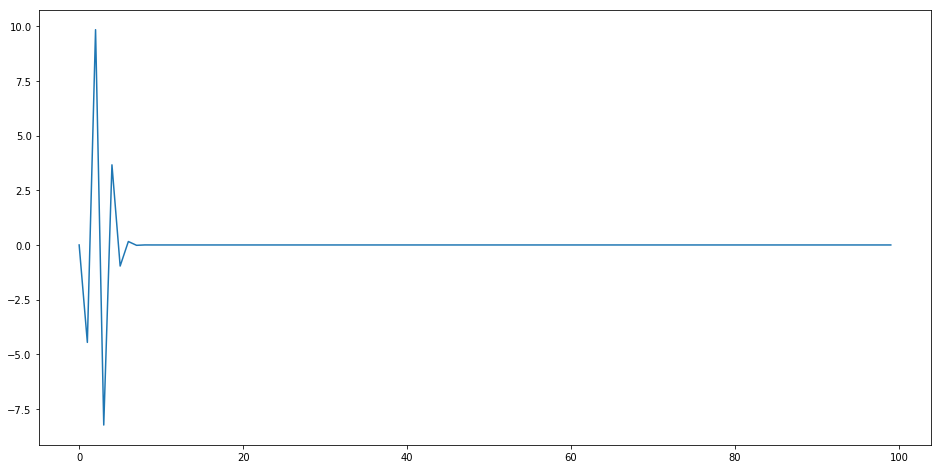

In [66]:
plt.plot(fft(wav))